

# Case Study: SMS Spam Classification
**27 Maret 2022, Materi NLP_03 

Created by NLP SQUAD Orbit Future Academy<br>

Teman-teman semua, pada hari ini

Skema yang akan kita selesaikan seperti pada gambar di bawah ini.

![title](https://undangmi.com/wp-content/uploads/2022/03/Screen-Shot-2022-03-27-at-10.59.13.png)

1. Data collection
2. Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Extraction
   1. BoW
   2. TF-IDF
4. Feature Selection
   1. Chi-Square
5. Machine Learning
   1. Naive Bayes
   2. SVM
6. Evaluation dan Validation
   1. Accuracy
   2. Precision
   3. Recall
   4. F-Measure

7. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 5.4 MB/s 


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Acquisition

Penjelasan Label 
* 0: SMS normal 
* 1: SMS fraud atau penipuan 
* 2: SMS promo

In [4]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-04-19 09:53:38--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.02s   

2022-04-19 09:53:39 (5.92 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv')

data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [7]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



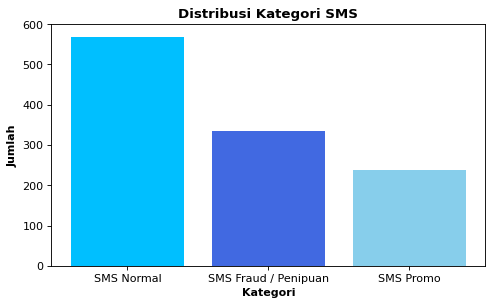

In [8]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# Text Preprocessing

## Case Folding

In [9]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               
  text = re.sub(r'https?://\S+|www\.\S+', '', text) 
  text = re.sub(r'[-+]?[0-9]+', '', text)           
  text = re.sub(r'[^\w\s]','', text)                
  text = text.strip()
  return text

In [10]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


## Word Normalization

In [11]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-04-19 09:53:39--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.01s   

2022-04-19 09:53:39 (6.15 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [12]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [14]:
len(stopwords_ind)

758

In [15]:
# Lihat daftar stopword yang disediakan NLTK
#stopwords_ind

In [16]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [17]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


## Stemming

In [18]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [19]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming		:  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


## Text Preprocessing Pipeline

In [20]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)


In [ ]:
data

In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# Feature Engineering

In [ ]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [ ]:
X

In [ ]:
y

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [ ]:
#save model
import pickle


from sklearn.feature_extraction.text import TfidfVectorizer


vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))
vec_TF_IDF.fit(X)

x_tf_idf = vec_TF_IDF.transform(X)

#Save vectorizer.vocabulary_
pickle.dump(vec_TF_IDF.vocabulary_,open("feature_tf-idf.pkl","wb"))

In [ ]:
#Menampilkan vocabulary dari TF-IDF
vec_TF_IDF.vocabulary_

In [ ]:
#Melihat Jumlah Fitur
print (len(vec_TF_IDF.get_feature_names()))

In [ ]:
#Melihat fitur-fitur apa saja yang ada di dalam corpus kita
print(vec_TF_IDF.get_feature_names())

In [ ]:
#Lihat data tabular yang menggunakan metode TF-IDF
#Data ini siap untuk dimasukkan dalam proses machine learning

x1 = vec_TF_IDF.transform(X).toarray()
data_tabular_tf_idf= pd.DataFrame(x1,columns=vec_TF_IDF.get_feature_names())
data_tabular_tf_idf

## Feature Selection

In [ ]:
#Mengubah nilai data tabular tf-idf & y dari dataframe menjdi array agar dapat dijalankan pada proses seleksi fitur
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

In [ ]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 


chi2_features = SelectKBest(chi2, k = 3000) 
X_kbest_features = chi2_features.fit_transform(x_train, y_train) 
  
# Reduced features 
print('Original feature number:', x_train.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
Data =pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
Data

In [ ]:
#Menampilkan fitur beserta nilainya
feature =vec_TF_IDF.get_feature_names()
feature

Data['Fitur'] = feature
Data

In [ ]:
#Mengurutkan fitur terbaik
Data.sort_values(by='Nilai', ascending=False)

In [ ]:
#Menampilkan mask pada feature yang diseleksi
#False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask =chi2_features.get_support()
mask

In [ ]:

new_feature=[]
for bool,f in zip(mask,feature):
    if bool:
        new_feature.append(f)
    selected_feature=new_feature
selected_feature

In [ ]:
# Membuat vocabulary baru berdasarkan fitur yang terseleksi
#Ini digunakan untuk mengenerate fitur vector tf-idf pada proses deployment

new_selected_features = {}

for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_features[k] = v

new_selected_features





In [ ]:
#Melihat jumlah fitur baru 
#Ini sesuai dengan nilai k pada chi-square
len(new_selected_features)

In [ ]:
#Save vectorizer.vocabulary_
#Menyimpan vektor dari vocabulary di atas dalam bentuk pickle (.pkl)
pickle.dump(new_selected_features,open("selected_feature_tf-idf.pkl","wb"))

In [ ]:
#Menampilkan Fitur-fitur yang sudah diseleksi 
#beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses Machine learning

#menampilkan fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features,columns=selected_feature)
data_selected_feature

In [ ]:
selected_x = X_kbest_features
selected_x

# Modelling (Machine Learning)

In [ ]:
#Import Library
import random
from sklearn.model_selection import train_test_split

#Algoritme
#Algoritme yang dikomparasi
from sklearn import svm
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [ ]:
x = selected_x
y = data.label
#Memisihkan data training dan data testing dengan perbandingan 80:20
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

In [ ]:
#print
print('Banyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))

In [ ]:
#Training Model
from datetime import datetime
from joblib import dump

In [ ]:
%%time
#algoritme fitting
text_algorithm = MultinomialNB()

model = text_algorithm.fit(x_train, y_train)

# save the model to disk
dump(model, filename="model_sentiment_naive.joblib")

In [ ]:
%%time
text_algorithm_svm = svm.SVC(kernel="rbf", C=1.0)
model_svm = text_algorithm_svm.fit(x_train, y_train)
dump(model_svm, filename="model_sentiment_svm.joblib")

In [ ]:
#Prediksi
predicted = model.predict(x_test)
predicted_svm = model_svm.predict(x_test)
#Hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted

In [ ]:
stop

# Model Evaluation

In [ ]:
#Library evaluasi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def model_evaluation(predicted, y_test):
  #Compute performance manually
  NewprediksiBenar = (predicted == y_test).sum()
  NewprediksiSalah = (predicted != y_test).sum()
      
  print("prediksi benar: ", NewprediksiBenar, " data")
  print("prediksi salah: ", NewprediksiSalah, " data")
  print("Akurasi Algoritme: ", NewprediksiBenar/(NewprediksiBenar+NewprediksiSalah)*100,"%")

  CM = confusion_matrix(y_test,predicted)

  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  precision    = TP/(TP+FP)
  recall       = TP/(TP+FN)
  print ("TRUE NEGATIVE (TN):",TN)
  print ("FALSE NEGATIVE (FN):",FN)
  print ("TRUE POSITIVE (TP):",TP)
  print ("FALSE POSITIVE (FP):",FP)
  print ("PRECISION:",precision*100,"%")
  print ("RECALL:",recall*100,"%")
  print(classification_report(y_test,predicted))

In [ ]:
#Menggunakan Cross Validation untuk memvalidasi data

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv        = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
accuracy= (cross_val_score(model,x,y,cv=cv,scoring='accuracy'))
score_accuracy = np.mean(accuracy)
print ("accuracy: ",accuracy)
print ("accuracy: ",score_accuracy)

# Deployment

In [ ]:
from joblib import load
#Hasil
pipeline = load("model_sentiment_naive.joblib")

data_input = input("Masukkan sentiment:\n")
data_input = text_preprocessing_process(data_input)

#Load
tfidf = TfidfVectorizer


#loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(new_selected_features))
loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(pickle.load(open("selected_feature_tf-idf.pkl", "rb"))))

hasil = pipeline.predict(loaded_vec.fit_transform([data_input]))

#print("Hasil Preprocessing:\n", proses)

if(hasil==0):
    s ="SMS Normal"
elif (hasil==1):
    s ="SMS Fraud"
else:
    s ="SMS Promo"
    
print("Hasil prediksi:\n", s) 

# WordCloud

In [ ]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [ ]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

In [ ]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

In [ ]:
# WordCloud Label SMS Normal

sms_normal = data[data.label == 0]
normal_string = []

for t in sms_normal.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud Label SMS Fraud / Penipuan

sms_fraud = data[data.label == 1]
fraud_string = []

for t in sms_fraud.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud Label SMS Promo

sms_promo = data[data.label == 2]
promo_string = []

for t in sms_promo.clean_teks:
  promo_string.append(t)

promo_string = pd.Series(promo_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(promo_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Student Activity
Lakukan proses di atas menggunakan dataset review product https://drive.google.com/file/d/1qn5WXp-H95_FL_Rx5oqvfZaflYdHsnrF/view?usp=sharing

! Ingat <br>
Kolom Ratings adalah target anda.

Tugas Anda:
- mahasiswa ditugaskan untuk menemukan model terbaik. Mahasiswa bisa menggunakan algoritme supervised learning lainnya 

Setelah dikerjakan, buatlah resume berdasarkan pengalaman Anda dalam membuat model ML dan proses evaluasinya

Kumpulkan tugas Anda pada: https://s.id/tugas-nlp-ofa



##  Isi resume di sini yah

Resume ......

# Modelling

In [ ]:
#Import Library
import random
from sklearn.model_selection import train_test_split

#Algoritme
#Algoritme yang dikomparasi
from sklearn import svm
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
#Memisihkan data training dan data testing dengan perbandingan 80:20
x_train, x_test, y_train, y_test = train_test_split(X_kbest_features,y,test_size=0.2, random_state=0)

In [ ]:
#print
print('Banyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))

In [ ]:
#Training Model

from datetime import datetime
start_time = datetime.now()
from joblib import dump
#algoritme fitting

text_algorithm_mb = MultinomialNB()
text_algorithm_svm = svm.SVC(kernel="rbf", C=1.0)
text_algorithm_lr = LogisticRegression()

model_mb = text_algorithm_mb.fit(x_train, y_train)
model_svm = text_algorithm_svm.fit(x_train, y_train)
model_lr = text_algorithm_lr.fit(x_train, y_train)

# save the model to disk
dump(model_mb, filename="model_sentiment_naive.joblib")
dump(model_svm, filename="model_sentiment_svm.joblib")
dump(model_lr, filename="model_sentiment_lr.joblib")

end_time = datetime.now()
result_time  =end_time-start_time
print("Duration:",result_time)

#y_train

In [ ]:
#Prediksi
predicted_mb = model_mb.predict(x_test)
predicted_svm = model_svm.predict(x_test)
predicted_lr = model_lr.predict(x_test)

# Model Evaluation

In [ ]:
#Library evaluasi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Compute performance manually
def metrics(predicted, y_test):
  NewprediksiBenar = (predicted == y_test).sum()
  NewprediksiSalah = (predicted != y_test).sum()
      
  print("prediksi benar: ", NewprediksiBenar, " data")
  print("prediksi salah: ", NewprediksiSalah, " data")
  print("Akurasi Algoritme: ", NewprediksiBenar/(NewprediksiBenar+NewprediksiSalah)*100,"%")

  CM = confusion_matrix(y_test,predicted)

  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  print ("TRUE NEGATIVE (TN):",TN)
  print ("FALSE NEGATIVE (FN):",FN)
  print ("TRUE POSITIVE (TP):",TP)
  print ("FALSE POSITIVE (FP):",FP)
  print(classification_report(y_test,predicted_mb))

In [ ]:
print("MB Classification Report:")
metrics(predicted_mb, y_test)
print("\n\nSVM Classification Report:")
metrics(predicted_svm, y_test)
print("\n\nLogistic Regression Classification Report:")
metrics(predicted_lr, y_test)

In [ ]:
#Menggunakan Cross Validation untuk memvalidasi data

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

def cross_validation_model(X,y,model):
  cv        = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
  accuracy= (cross_val_score(model,X,y,cv=cv,scoring='accuracy'))
  score_accuracy = np.mean(accuracy)
  print ("accuracy: ",accuracy)
  print ("accuracy: ",score_accuracy)

In [ ]:
print("MB Classification Report:")
cross_validation_model(X_kbest_features,y,model_mb)


print("\n\nSVM Classification Report:")
cross_validation_model(X_kbest_features,y,model_svm)

print("\n\nLogistic Regression Classification Report:")
cross_validation_model(X_kbest_features,y,model_lr)